In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from plyfile import PlyData, PlyElement
import tqdm
import sys 
sys.path.append('../')
import radfoam
from radfoam_model.render import TraceRays
from radfoam_model.utils import *

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import KDTree
import random
import meshplot as mp
import mesh_tools as mt

In [2]:
def generate_fixed_color_map(point_cloud):
    """Assigns a fixed random color to each unique point index."""
    unique_indices = np.arange(len(point_cloud))  # Each point has a fixed index
    color_map = {idx: np.random.rand(3) for idx in unique_indices}  # Assign random colors
    return color_map

def triangle_case1(tet, values, points):
    diff = torch.tensor(tet[values>0]).repeat_interleave(3).long()
    rest = tet[values<0]
    new_points = (points[diff]+points[rest])/2.
    new_tri = torch.arange(len(new_points)).reshape(len(new_points)//3,3)
    return new_points, new_tri

def triangle_case2(tet, values, points):
    diff = torch.tensor(tet[values>0]).long()
    rest = tet[values<0]
    p1p2 = (points[diff]+ points[rest])/2.
    p1 = p1p2[::2]
    p2 = p1p2[1::2]
    p3 = (points[diff][::2] + points[rest][1::2])/2.
    p4 = (points[diff][1::2] + points[rest][::2])/2.
    new_points = torch.cat((p1,p2,p3,p4))
    ls = len(p1)
    new_tri = torch.tensor([[0,2*ls,3*ls], [1*ls,3*ls,2*ls]]).repeat(ls,1)
    new_tri += torch.arange(len(p1)).repeat_interleave(2)[:, None]
    return new_points, new_tri

def marching_tetraheadra(tet_adjacency, primal_values, points):
    values = primal_values[tet_adjacency]
    pos = (values>0).sum(1).long()
    # triangle case 
    new_v, new_f = [], []
    cur_ind = 0
    for i in [1,3]:
        if (pos==i).sum()>0:
            new_points, new_tri = triangle_case1(tet_adjacency[pos==i], (-1)**(i//2)*values[pos==i], points)
            new_v.append(new_points)
            new_f.append(cur_ind+new_tri)
            cur_ind += len(new_points)
    new_points, new_tri = triangle_case2(tet_adjacency[pos==2], values[pos==2], points)
    new_v.append(new_points)
    new_f.append(cur_ind+new_tri)
    return torch.cat(new_v).cpu().detach().numpy(), torch.cat(new_f).cpu().detach().numpy()

def tets_to_edges(tets): 
    edges = []
    edges.append(torch.column_stack((tets[:, 0], tets[:, 1])))
    edges.append(torch.column_stack((tets[:, 0], tets[:, 2])))
    edges.append(torch.column_stack((tets[:, 0], tets[:, 3])))
    edges.append(torch.column_stack((tets[:, 1], tets[:, 2])))
    edges.append(torch.column_stack((tets[:, 1], tets[:, 3])))
    edges.append(torch.column_stack((tets[:, 2], tets[:, 3])))
    return torch.cat(edges).view(-1,2)

def apply_lloyd_iterations(primal_points,triangulation,n_iterations=100):
    
    needs_permute = False
    perturbation = 1e-6
    failures = 0
    for _ in range(n_iterations):
        point_adjacency = triangulation.point_adjacency()
        point_adjacency_offsets = triangulation.point_adjacency_offsets()
        new_centroids = radfoam.centroidal_voronoi_tessellation_single_iteration(primal_points, point_adjacency, point_adjacency_offsets)
        is_not_extreme = (torch.norm(primal_points,dim=1,keepdim=True) < 30).any(1)
        primal_points[is_not_extreme,:] = new_centroids[is_not_extreme,:]
        # primal_points = new_centroids
        while True:
            if failures > 25:
                raise RuntimeError("aborted triangulation after 25 attempts")
            try:
                needs_permute = triangulation.rebuild(
                    primal_points, incremental=True
                )
                break
            except radfoam.TriangulationFailedError as e:
                print("caught: ", e)
                perturbation *= 2
                failures += 1
                incremental = False
                with torch.no_grad():
                    primal_points = (
                        primal_points
                        + perturbation * torch.randn_like(primal_points)
                    )
            if needs_permute:
                perm = triangulation.permutation().to(torch.long)
                primal_points = primal_points[perm]
    return primal_points

def visualize_2D_plane(points,min_max=None,color_map=None):
    
    # Take a 2D slice at z = 0
    # Determine the grid bounds based on min/max values of the point cloud
    if min_max is None:
        # x_min, y_min = np.min(points[:, :2], axis=0)
        # x_max, y_max = np.max(points[:, :2], axis=0)
        x_min, y_min = -30.0,-30.0
        x_max, y_max = 30.0, 30.0
    else:
        x_min,x_max,y_min,y_max = min_max

    # Define grid resolution
    grid_size = 200  # Adjust for desired resolution
    x_vals = np.linspace(x_min, x_max, grid_size)
    y_vals = np.linspace(y_min, y_max, grid_size)

    # Create a 2D grid in the xy-plane at z = 0, now in 3D
    grid_x, grid_y = np.meshgrid(x_vals, y_vals)
    xy_plane = np.column_stack((grid_x.ravel(), grid_y.ravel(), np.zeros(grid_x.size)))  # Shape (grid_size^2, 3)

    tree = KDTree(points)  # Use only (x, y) coordinates
    tmp, indices = tree.query(xy_plane)  # Find nearest point indices
    # Generate a colormap where each index has a unique color

    # Generate random colors for each unique index
    unique_indices = np.unique(indices)
    if color_map is None:
        color_map = {idx: np.random.rand(3) for idx in unique_indices}  # Assign random RGB color to each index

    # Convert index assignments to a 2D image
    image = np.zeros((grid_size, grid_size, 3))  # RGB image
    for i, (x, y, _) in enumerate(xy_plane):
        x_idx = np.searchsorted(x_vals, x) - 1  # Convert to image indices
        y_idx = np.searchsorted(y_vals, y) - 1  
        if indices[i] not in color_map:
            color_map[indices[i]] = np.random.rand(3)
        image[y_idx, x_idx] = color_map[indices[i]]
    
    return (x_min,x_max,y_min,y_max), image, color_map

def plot_voronoi_images(image1, image2, title1="Voronoi Diagram Before", title2="CVT",save_filename=None):
    """Plots two Voronoi images side by side in a clean layout."""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Two side-by-side plots

    # Display Image 1
    axes[0].imshow(image1)
    axes[0].set_title(title1, fontsize=14, fontweight="bold")
    axes[0].axis("off")  # Hide axes for a clean look

    # Display Image 2
    axes[1].imshow(image2)
    axes[1].set_title(title2, fontsize=14, fontweight="bold")
    axes[1].axis("off")  

    # Adjust layout for aesthetics
    # plt.tight_layout()
    if save_filename is None:
        plt.show()
    else:
        plt.savefig(save_filename,dpi=300)
        plt.close(fig)

def tetraCoord(tet_points):
    v1 = tet_points[:, 1] - tet_points[:, 0]
    v2 = tet_points[:, 2] - tet_points[:, 0]
    v3 = tet_points[:, 3] - tet_points[:, 0]
    mat = torch.stack((v1,v2,v3)).permute((1, 0, 2))
    M1 = torch.inverse(mat)
    return M1

def pointInside(tet_points, p):
    M1 = tetraCoord(tet_points)
    newp = M1.bmm((p-tet_points[:, 0])[..., None]).squeeze()
    cond = (newp>=0)*(newp <=1)*(newp.sum(-1, keepdim=True)<=1)
    return cond.all(-1)

In [3]:
class AugmentedTriangulation:
    def __init__(self, primal_points: torch.tensor) -> None:
        self.triangulation = radfoam.Triangulation(primal_points)
        perm = self.triangulation.permutation().to(torch.long)
        self.points = primal_points[perm] 
        self.tree = radfoam.build_aabb_tree(self.points)
        
    @property
    def tets(self):
        return self.triangulation.tets().long()
    
    @property
    def tets_neighbors(self):
        neighs = ((self.triangulation.tet_adjacency().long())//4)
        neighs[neighs>len(self.tets)] = -1
        return neighs
    
    @property
    def triangle_faces(self):
        opp_face = torch.tensor([[1, 2, 3], [0, 3, 2], [0, 1, 3], [0, 2, 1]], device=device)
        return self.tets[:, opp_face]
    
    @property 
    def tet_bary(self):
        return self.points[self.tets].mean(-2)
    
    def signed_volume(self, P, queries):
        '''TODO DEBUG'''
        p1 = P[:,:,1] - P[:,:,0]
        p2 = P[:,:,2] - P[:,:,0]
        p3 = queries[:, None] - P[:,:,0]
        return torch.det(torch.stack((p1, p2, p3), dim=-1))

    def signed_normal(self, P, queries):
        p1 = P[:,:,1] - P[:,:,0]
        p2 = P[:,:,2] - P[:,:,0]
        face_normal = torch.cross(p1, p2, dim=-1)
        sign = ((queries[:, None]-P.sum(-2))*face_normal).sum(-1)
        return sign
        
    def query_to_tet(self, queries, max_iter=100):
        nearest_neighbor = radfoam.nn(self.points, self.tree, queries)
        tet_index = self.triangulation.vert_to_tet().long()[nearest_neighbor.long()]
        to_see = torch.ones(len(queries), dtype=torch.bool, device=queries.device)
        for i in range(max_iter):
            P = self.points[self.triangle_faces[tet_index[to_see]]] 
            signed_volume = self.signed_normal(P, queries[to_see])
            smin, sargmin = signed_volume.min(-1)
            to_see[torch.arange(len(to_see), device=device)[to_see][smin>=0]] = False
            tet_index[to_see] = self.tets_neighbors[tet_index[to_see], sargmin[smin<0]]
            if to_see.sum()==0:
                break
        return tet_index



In [4]:
# Initialize all points randomly.
device='cuda'
num_init_points = 300000
primal_points = (
torch.rand(num_init_points, 3, device=device) - 0.5
)*2
# primal_values = torch.rand(num_init_points, device=device) - 0.5
triangulation = radfoam.Triangulation(primal_points)
tree = radfoam.build_aabb_tree(primal_points)
perm = triangulation.permutation().long()
primal_points = primal_points[perm]

# primal_values = (torch.norm(primal_points,dim=1) < .4)*1.  - 0.5

v, f, samples = mt.load_and_sample_shape('pig.obj', 'toy_data/',)
queries = torch.tensor(samples, device='cuda', dtype=torch.float32) 
nearest_neighbor = radfoam.nn(primal_points, tree, queries)

tet_index = triangulation.vert_to_tet().long()[nearest_neighbor.long()]
tet_points = primal_points[triangulation.tets().long()[tet_index]]
tet_bary = tet_points.mean(-2)
mask_inside = pointInside(tet_points, queries)


augmented_triangulation = AugmentedTriangulation(primal_points)
query_tet = augmented_triangulation.query_to_tet(queries)

primal_values = torch.ones_like(primal_points[:, 0])
primal_values[augmented_triangulation.tets[query_tet].unique()] = -1

In [5]:
v,f = mt.marching_tetraheadra(triangulation.tets().long(),primal_values,primal_points)
mp.plot(v.detach().cpu().numpy(),f.detach().cpu().numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0166392…

In [22]:
import torch
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, RasterizationSettings,
    SoftPhongShader, PointLights, PerspectiveCameras, TexturesVertex
)

from pytorch3d.renderer import look_at_view_transform

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example mesh (triangle)
verts = v.unsqueeze(0)
faces = f.unsqueeze(0).cuda()
textures = TexturesVertex(verts_features=torch.ones_like(verts))  # White color

# Create a Meshes object
mesh = Meshes(verts=verts, faces=faces, textures=textures)

# Camera setup
# Define a camera positioned at (0, 0, +3) looking towards the origin
distance = 0.6
elevation = 0    # No vertical tilt
azimuth = 30     # Rotate 30° around Y-axis

R, T = look_at_view_transform(dist=distance, elev=elevation, azim=azimuth)

cameras = PerspectiveCameras(device=device, R=R, T=T)
# Lighting
lights = PointLights(device=device, location=[[0, 0, 3]])

# Rasterization settings
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1
)

# Define rasterizer
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

# Define shader (Phong shading)
shader = SoftPhongShader(device=device, cameras=cameras, lights=lights)

# Create the MeshRenderer
renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

# Render the image
images = renderer(mesh)

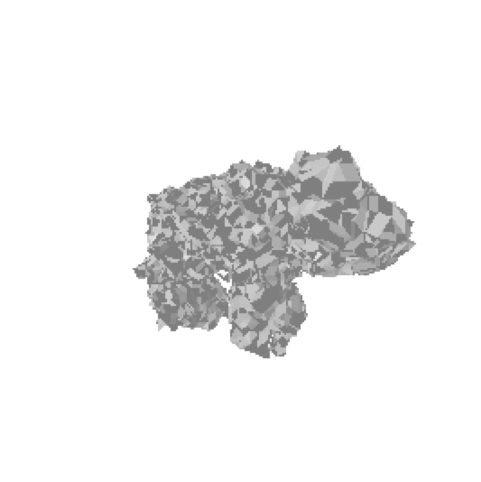

In [25]:
# Convert to numpy and remove batch dimension
image = images.squeeze().detach().cpu().numpy()  # (H, W, 4)

# Remove alpha channel (RGBA → RGB)
image_rgb = image[..., :3]  # Keep only the first 3 channels (RGB)

# Clip values to ensure valid image range
image_rgb = image_rgb.clip(0, 1)

# Plot the image
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
plt.imshow(image_rgb)
plt.axis("off")  # Hide axes for a clean look
plt.show()